### **Projet de réassurance 2024**  
**Calibrage d'un programme en Top & Drop**  
*Louis Bolzinger*  
*Paul Noiret*


#### **Importation**

In [1]:
#pip install pyextremes
#necessite d'avoir R studio d'installé
#pip install thresholdmodeling 


In [29]:
import pandas as pd
import plotly.express as px
px.defaults.template = "plotly_white"
px.defaults.width = 800
px.defaults.height = 400

from functools import reduce
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.stats import genpareto



from scipy.stats import poisson

In [3]:
df = pd.read_csv("fire_denmark.csv")

# Convertir la colonne "Date" en datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month


#https://donnees.banquemondiale.org/indicateur/NY.GDP.DEFL.KD.ZG?locations=DK  source indice inflation
dfi = pd.read_csv("inflation.csv")
dfi = dfi.T
nouvelles_colonnes = dfi.iloc[0]
dfi = dfi[1:]
dfi.columns = nouvelles_colonnes
dfi = dfi.reset_index()
dfi = dfi.rename(columns={'index': 'Année'}).loc[21:31]
dfi['Année'] = dfi['Année'] .astype(int)


#### **Question 1** Faire  quelques  statistiques  descriptives  et  tracés  pour  décrire  les  sinistres  dont  vous disposez. 

In [4]:

def generate_descriptive_plots(df, loss_column):
    # Statistiques descriptives
    stats_descriptives = df[loss_column].describe()
    print("Statistiques descriptives pour les sinistres :\n", stats_descriptives)

    # Histogramme de la distribution des sinistres
    histogram = px.histogram(df, x=loss_column, title="Distribution des sinistres")
    histogram.show()

    # Nombre de sinistres par année
    sinistres_par_annee = df.groupby('Year').size().reset_index(name='Nombre de sinistres')
    evolution_sinistres = px.line(sinistres_par_annee, x='Year', y='Nombre de sinistres',
                                   title="Évolution du nombre de sinistres par année")
    evolution_sinistres.show()

    # Évolution du coût moyen, maximum et minimum par année
    annee_stats = df.groupby('Year').agg({loss_column: ['mean', 'max', 'min']}).reset_index()
    annee_stats.columns = ['Year', 'Coût moyen', 'Coût maximum', 'Coût minimum']
    fig = px.line(annee_stats, x='Year', y=['Coût moyen', 'Coût maximum', 'Coût minimum'],
                  title="Évolution des coûts par année")
    fig.show()

    # Nombre moyen de sinistres par mois
    moyenne_sinistres_par_mois = df.groupby(['Year', 'Month']).size().groupby('Month').mean().reset_index(name='Nombre moyen de sinistres')
    fig = px.line(moyenne_sinistres_par_mois, x='Month', y='Nombre moyen de sinistres',
                  title="Nombre moyen de sinistres par mois")
    fig.show()


generate_descriptive_plots(df, 'LossY')


Statistiques descriptives pour les sinistres :
 count    2167.000000
mean        2.609839
std         6.226331
min         0.727080
25%         1.014092
50%         1.354302
75%         2.284627
max       141.732360
Name: LossY, dtype: float64


#### **Question 2** Revaloriser les sinistres à l’aide d’un indice d’inflation judicieusement choisi. Réalisez les mêmes statistiques descriptives que la question précédente sur les sinistres ajustés. Commenter. 

In [5]:
dfi['Indice_cumulatif'] = 0
dfi['Inflation'] = 0
inflation = dfi['Danemark'].tolist()

for i in range(dfi.shape[0]):
    liste = inflation[:i+1]
    liste = [x/100 + 1 for x in liste]
    dfi.iloc[i, -2] = reduce(lambda x, y: x * y, liste) - 1
    dfi.iloc[i, -1] = inflation[i]

dfi

Country Name,Année,Danemark,Indice_cumulatif,Inflation
21,1981,10.693958,0.106940,10.693958
22,1982,10.144536,0.219233,10.144536
23,1983,7.385841,0.309284,7.385841
24,1984,5.959391,0.387309,5.959391
25,1985,4.290954,0.446838,4.290954
26,1986,2.315586,0.480341,2.315586
27,1987,4.754689,0.550727,4.754689
28,1988,3.944579,0.611896,3.944579
29,1989,4.965285,0.691932,4.965285
30,1990,2.602447,0.735963,2.602447


In [6]:
df['Loss As IF'] = 0

for i in range(df.shape[0]):
    if df.loc[i, 'Year'] == 1980 : inflation = 0
    else : inflation = dfi.loc[dfi['Année'] == df.loc[i, 'Year'], 'Indice_cumulatif'].values[0]

    df.loc[i,'Loss As IF'] = df.loc[i, 'LossY']/( 1 + inflation)

generate_descriptive_plots(df, 'Loss As IF')

Statistiques descriptives pour les sinistres :
 count    2167.000000
mean        1.819582
std         4.482053
min         0.544588
25%         0.715330
50%         0.953030
75%         1.599140
max       132.049491
Name: Loss As IF, dtype: float64


In [7]:
annee_stats = df.groupby('Year').agg({'LossY': ['mean'], 'Loss As IF': ['mean']}).reset_index()
annee_stats.columns = ['Year', 'Coût moyen', 'Coût moyen AS IF']
fig = px.line(annee_stats, x='Year', y=['Coût moyen', 'Coût moyen AS IF'],
                title="Évolution des coûts par année")
fig.show()

#### **Question 3** Proposer une modélisation des sinistres à l’aide de la théorie des valeurs extrêmes. Justifier le choix du seuil des atypiques, et modéliser les sinistres extrêmes et les sinistres attritionnels.

On procède à la définition du seuil de 3 manière différentes

In [8]:
losses = df.set_index('Date')['Loss As IF']
losses.index = pd.to_datetime(losses.index)
losses.index.name = None


<Axes: xlabel='Threshold', ylabel='Mean excess'>

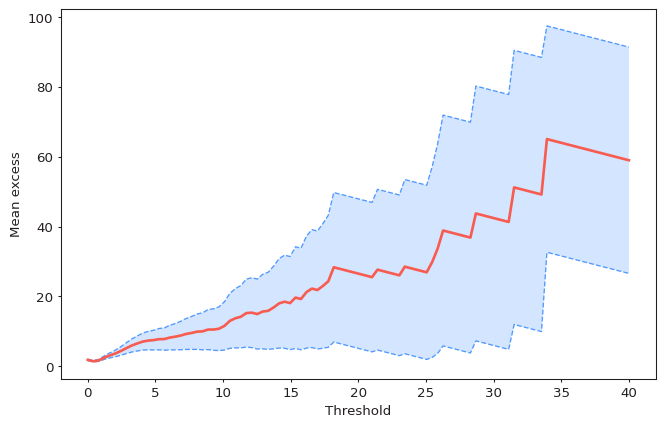

In [9]:
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(losses, thresholds=np.linspace(0, 40, 100))


A partir de la ce sont des fonctions qui ne marchent pas, a corriger donc pour déterminer le meilleur seuil

In [10]:
from pyextremes import plot_parameter_stability

losses2 = losses[:110]
plot_parameter_stability(losses2)


(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

In [11]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes

extremes = get_extremes(losses2, "BM")
plot_extremes(
    ts=losses,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
)

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='date-time', ylabel='Loss As IF'>)

In [ ]:
plt.show()

en attente d'avoir un truc qui marche, j'ai pris le seuil suivant par défaut

In [12]:
seuil = 10
df_attritionnels = df[df['Loss As IF'] < seuil]
df_extremes = df[df['Loss As IF'] >= seuil]


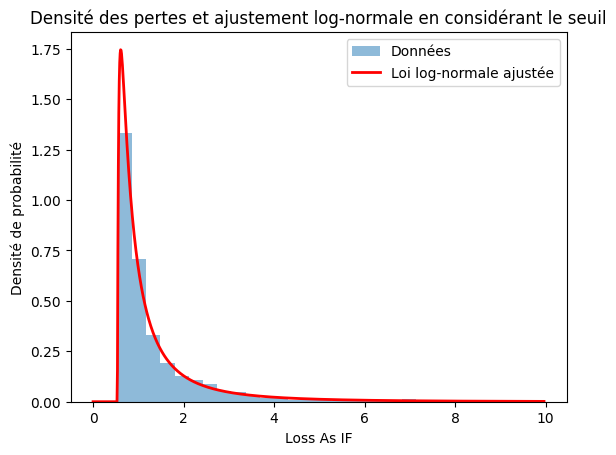

In [60]:
loss_data = df_attritionnels['Loss As IF'].values

shape, loc, scale = lognorm.fit(loss_data)

x = np.linspace(0, np.max(loss_data), 1000)
pdf = lognorm.pdf(x, shape, loc, scale)


plt.hist(loss_data, bins=30, density=True, alpha=0.5, label='Données')
plt.plot(x, pdf, 'r-', lw=2, label='Loi log-normale ajustée')
plt.xlabel('Loss As IF')
plt.ylabel('Densité de probabilité')
plt.title('Densité des pertes et ajustement log-normale en considérant le seuil')
plt.legend()
plt.show()


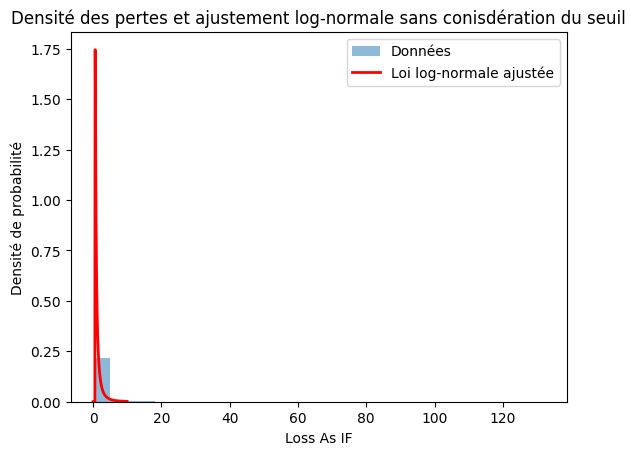

In [15]:
loss_data2 = df['Loss As IF'].values

shape2, loc2, scale2 = lognorm.fit(loss_data)
pdf2 = lognorm.pdf(x, shape2, loc2, scale2)

plt.hist(loss_data2, bins=30, density=True, alpha=0.5, label='Données')
plt.plot(x, pdf2, 'r-', lw=2, label='Loi log-normale ajustée')
plt.xlabel('Loss As IF')
plt.ylabel('Densité de probabilité')
plt.title('Densité des pertes et ajustement log-normale sans conisdération du seuil')
plt.legend()
plt.show()


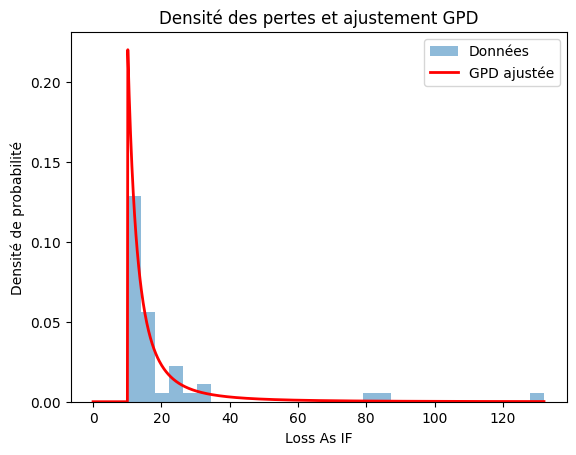

In [59]:
loss_data = df_extremes['Loss As IF'].values
params = genpareto.fit(loss_data)

x = np.linspace(0, np.max(loss_data), 1000)
pdf_xtrm = genpareto.pdf(x, *params)

plt.hist(loss_data, bins=30, density=True, alpha=0.5, label='Données')
plt.plot(x, pdf_xtrm, 'r-', lw=2, label='GPD ajustée')
plt.xlabel('Loss As IF')
plt.ylabel('Densité de probabilité')
plt.title('Densité des pertes et ajustement GPD')
plt.legend()

plt.show()


*faire des graphes qqplot pour vérifier l'adéquation & test khi 2 ou kolgo*

On modélise la fréquence des sinistres a l'aide d'une loi de poisson

In [58]:
mean_freq = df.groupby('Year').size().mean()

poisson_dist = poisson(mu=mean_freq)

*tracer un grpahe pour voir si ca a bien fité*

In [87]:
def simulation_nb_event(nb_an, poisson_dist): 
    simulated_values = poisson_dist.rvs(size=nb_an)
    simulated_event = pd.Series(simulated_values, index=range(0,  nb_an))
    simulated_event.index.name = 'Year'
    simulated_event.name = 'Nb Event'
    return simulated_event

def simulation_losses(seuil, shape, loc, scale, params, nb_an , poisson_dist):
    simulated_event = simulation_nb_event(nb_an, poisson_dist)
    
    df = pd.DataFrame(columns=['Year', 'Loss As IF'])

    for i in range(nb_an): 
        nb_event = simulated_event[i]
        for j in range(nb_event): 
           loss = lognorm.rvs(shape, loc, scale, size=1)
           if loss > seuil : 
               loss = genpareto.rvs(*params, size=1)
           df.loc[len(df)] = [i, loss[0]]

    return df

df_simulated = simulation_losses(seuil, shape, loc, scale, params, 10, poisson_dist)

df_simulated


,Year,Loss As IF
0,0.0,0.772246
1,0.0,0.700688
2,0.0,0.589639
3,0.0,0.717508
4,0.0,0.593859
...,...,...
2054,10.0,1.647198
2055,10.0,0.962412
2056,10.0,0.606934
2057,10.0,1.008895


#### **Question 4** Tarifer la tranche en XoL et la tranche XS Aggregate.



Pour  rappel,  la  cédante  est  actuellement  couverte  en  125  XS  5.    

 
- Pour couvrir les extrêmes, la cédante envisage une structure en XoL en 200 XS 130 
– 1@120% 
- Pour couvrir la fréquence, la cédante envisage une structure en XS Aggregate en 
200 XS 500 

Une  tranche  en  XS Aggregate consiste à sommer les rétentions de chaque sinistre sur une année, et de faire 
passer cet agrégat dans une tranche en XoL. 
 

Prendre rétention d’une année, les sommer, et faire passer ca dans un b XS a , y aura une rétention finale 

Reconstitution : b XS a , si un sinistre qui survient : si on a tout consommer, le prochain sin ne sera 
pas indemne, si un sin consomme une partie de la tranche, le reste indemnisera au max du prochain sin. 
Si on pense qu’il y aura plus d’un sin

Exprime en pct du prix initial de la tranche 
Reconstruire en 120% : on peut consommer 2 fois la tranche : 1 fois normal,  autre fois a 120 % , 
on peut avoir autant de sinistre dans que ca n’excède pas 2 fois la portée 

2 Greco en bas de programme, 1 en milieux


E(L)  + Recon - Primes = 0 down estimer la prime 
Prime = prime init + primes de rec = P0( 1 + 120%) checker les slides 

##### XoL

In [89]:
def tarifer_xol(nb_run, seuil, shape, loc, scale, params, nb_an = 11): 
    total = 0
    b = 200
    a = 130
    for i in range(nb_run): 

        df_simulated = simulation_losses(seuil, shape, loc, scale, params, nb_an, poisson_dist)
        
        losses = df_simulated[df_simulated['Loss As IF'] >= a]
        losses = losses['Loss As IF']
        final_retention = (losses - a).clip(upper = b)
        total = final_retention.sum()
        primes_XoL = total/nb_an

        total += primes_XoL
    return total/ nb_an


nb_run = 10
primes_Xol = tarifer_xol(nb_run, seuil, shape, loc, scale, params, nb_an = 11)
primes_Xol

0.0

*assez rare d'avoir un sin extreme , essayer avec plus de run plsu d'an, ou requalibrer les lois*

##### XS Aggregate

In [90]:

def tarifer_xs(nb_run, seuil, shape, loc, scale, params, nb_an = 11): 
    
    total = 0
    for i in range(nb_run): 
        df_simulated = simulation_losses(seuil, shape, loc, scale, params, nb_an, poisson_dist)
        b = 125
        a = 5
        losses = df_simulated[df_simulated['Loss As IF'] < a] # on ne garde que les rétentions
        aggregate_losses = losses.groupby('Year')['Loss As IF'].sum()

        b = 500
        a = 200
        final_retention = (aggregate_losses - a).clip(lower=0, upper = b) 
        total_ = final_retention.sum()
        primes_agg = total_/nb_an

        total += primes_agg

    return total/ nb_an


nb_run = 5
primes_agg = tarifer_xs(nb_run, seuil, shape, loc, scale, params, nb_an = 11)
primes_agg

32.662762827657204

#### **Question 5** Calculer le besoin en fonds propres de l’assureur avec ce programme de réassurance. 

On supposera  qu’il  est  égal  au  quantile  à  99.5%  des  pertes  annuelles,  conformément  à  la 
directive Solvabilité II. 

In [79]:
annual_losses = df.groupby('Year')['Loss As IF'].sum()

quantile_995 = annual_losses.quantile(0.995)

print("Pertes annuelles :\n", annual_losses)
print("\nQuantile à 99.5% des pertes annuelles :", quantile_995)


Pertes annuelles :
 Year
0.0    247.678325
1.0    245.178333
2.0    256.591926
3.0    258.242900
4.0    307.371180
5.0    327.843486
6.0    343.883557
7.0    326.865847
8.0    272.316772
9.0    366.883516
Name: Loss As IF, dtype: float64

Quantile à 99.5% des pertes annuelles : 365.8485182554236


#### **Question 6**

 
On  suppose  que  la  cédante  n'a  pas  le  budget  nécessaire  pour  se  couvrir  avec  ce 
programme de réassurance. Elle souhaite alors mettre en place une structure Top & Drop. 
 
Une telle structure consiste à mutualiser deux tranches de réassurance. 
Dans  notre  cas,  la  cédante  souhaite  mutualiser  la  tranche  en  XoL  et  la  tranche  en  XS 
Aggregate. Néanmoins, à la fin de l'année, elle ne touchera que les indemnités issues de 
la structure la plus avantageuse. 
 
Par exemple dans le cas de notre structure, si on suppose qu'un sinistre extrême de 200 
survient, et que la rétention du reste de la sinistralité s’élève à 550, alors le sinistre à 200 
consommera  70  de  la  tranche  en  XoL,  et  la  rétention  consommera  50  de  la  tranche  en 
Aggregate. Dans ce cas à la fin de l'année, la structure la plus avantageuse est la structure 
en XoL, et la cédante serait alors indemnisée de 70 uniquement, contre 120 si la cédante 
avait acheté les deux structures séparemment. 
 
**Discuter de l'intérêt d'une telle structure.**

La structure Top & Drop, également appelée "Structure T&D", est une méthode de réassurance qui combine deux tranches de réassurance : une tranche en Excess of Loss (XoL) et une tranche en XS Aggregate (Excess of Loss Agrégée). Cette combinaison vise à fournir une protection complète contre les pertes extrêmes tout en limitant les pertes potentielles dans les tranches inférieures.


L'intérêt principal de cette structure réside dans sa capacité à réduire le coût de la réassurance tout en offrant une protection adéquate contre les pertes extrêmes. Voici quelques avantages et considérations :

1. **Réduction des coûts**: En combinant deux tranches de réassurance, la structure T&D permet à la cédante de bénéficier de primes plus avantageuses que si elle avait acheté les deux tranches séparément. Cela peut réduire le coût global de la réassurance. L'offre est ainsi sur mesure et permet d'etre couvert contre les risques extrêmes, qui par définition arrivent peu fréquemment. Ainsi les années sans de telles manifestations, la cédante ne paie que ce qu'elle consomme dans sa rétention.

2. **Maintient de la protection contre les pertes extrêmes**: La tranche en XoL offre une protection contre les pertes individuelles importantes, tandis que la tranche XS Aggregate protège contre les pertes agrégées élevées sur une période donnée. En combinant ces deux types de protection, la cédante est mieux protégée contre une large gamme de scénarios de pertes.

3. **Flexibilité et adaptabilité**: La structure T&D peut être conçue sur mesure pour répondre aux besoins spécifiques de la cédante en termes de niveau de rétention, de limites de couverture et de seuils de déclenchement. Elle offre ainsi une grande flexibilité et peut être adaptée en fonction de l'évolution des risques.

4. **Optimisation de la capacité de réassurance**: En utilisant efficacement les capacités de réassurance disponibles, la structure T&D permet à la cédante d'optimiser l'utilisation de ses fonds propres tout en maintenant une protection adéquate contre les risques.

5. **Conjecture**: dans notre cas (incendie), on peut supposer qu'un sinistre important réduit l'exposition du plusieurs petits sinistres, et ainsi on peut éventuellement conjecturer une anti-corrélation entre la survenance d'un sinistre important et de petits sinistres. 


#### **Question 7** Tarifer cette structure de réassurance en supposant que la tranche en XoL et la tranche en Aggregate ont la même structure qu'à la question 4.

In [91]:

def tarifer_td(nb_run, seuil, shape, loc, scale, params, nb_an = 11):
    
    total = 0

    for i in range(nb_run): 

        df_simulated = simulation_losses(seuil, shape, loc, scale, params, nb_an, poisson_dist)


        b = 125
        a = 5

        losses = df_simulated[df_simulated['Loss As IF'] < a] # on ne garde que les rétentions

        aggregate_losses = losses.groupby('Year')['Loss As IF'].sum()

        b = 500
        a = 200

        final_retention1 = (aggregate_losses - a).clip(lower=0, upper = b) 


        b = 200
        a = 130
        nb_an = 11
        losses = df_simulated[df_simulated['Loss As IF'] >= a]
        losses = losses.groupby('Year')['Loss As IF'].sum()
        final_retention2 = (losses - a).clip(upper = b)


        result = final_retention1.combine(final_retention2, max)


        total_ = result.sum()
        primes_td = total_/nb_an
        total += primes_td
    
    return total/nb_an

nb_run = 5
primes_td = tarifer_td(nb_run, seuil, shape, loc, scale, params, nb_an = 11)
primes_td

18.552778156564596

#### **Question 8** Effectuer  des  analyses  de  sensibilités  sur  la  priorité  et  la  portée  de  chacune  des structures.  Commenter  ainsi  sur  le  mécanisme  de  mutualisation  des  tranches  (bonne mutualisation, moins bonne mutualisation, etc.) 

#### **Question 9** Calculer le besoin en fonds propres de ce programme.

#### **Question 10** Conclure. 